# pyTao advanced usage

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
from pytao import Tao, TaoModel, util, run_tao
from pytao.tao_ctypes.evaluate import evaluate_tao
import os
?TaoModel

Init signature:
TaoModel(
    input_file='tao.init',
    ploton=True,
    use_tempdir=True,
    workdir=None,
    verbose=True,
    so_lib='',
    auto_configure=True,
)
Docstring:     
Base class for setting up a Tao model in a directory. Builds upon the Tao class.

If use_tempdir==True, then the input_file and its directory will be copied to a temporary directory.
If workdir is given, then this temporary directory will be placed in workdir.
File:           ~/Code/bmad_svn/tao/python/pytao/tao_ctypes/core.py
Type:           type
Subclasses:     


## Inititialize Tao

In [3]:
# Point to local installation
BASE_DIR=os.environ['ACC_ROOT_DIR'] 
print('Bmad installation: ', BASE_DIR)

# Pick an example init
root = BASE_DIR+'tao/examples/csr_beam_tracking/'

INPUT_FILE = root+'tao.init'
assert os.path.exists(INPUT_FILE), INPUT_FILE

Bmad installation:  /Users/chrisonian/Code/bmad_svn/


# run_tao

In [4]:
M=run_tao(input_file=INPUT_FILE, ploton=True)
M

# evaluate_tao

In [5]:
?evaluate_tao

Signature:
evaluate_tao(
    settings,
    run_commands=['set global track_type=beam'],
    expressions=['lat::orbit.x[end]'],
    input_file=None,
    ploton=False,
    beam_archive_path=None,
    workdir=None,
    so_lib='',
    verbose=False,
)
Docstring:
settings: dict of set_command:value where set_command is a string.
    Example:
        'global:track_type':'beam'
            will issue command:
        set global track_type = beam

run_commands: list of command strings that will be executed.

expressions: list of expression strings that will be used to form the output.

beam_archive_path: if given, the all of the saved beams will be written to
    a file named by a fingerprint (hash) of the inputs into path beam_archive_path.
    This uses the command:
        write beam -at *
    which writes ALL of the bunches that are saved using the beam_saved_at list in beam_init. 

Returns a dict of expression:value, according to the expressions above, as well as 
    beam_archive if a  b

In [6]:
res = evaluate_tao(settings={}, 
                   input_file=root+'tao.init', 
                   run_commands=['set global track_type=beam'],
                   expressions = ['lat::orbit.x[FF.PIP02A]', 'beam::norm_emit.x[end]'],
                   ploton=False, 
                   beam_archive_path = '.')
res

{'lat::orbit.x[FF.PIP02A]': 0.0,
 'beam::norm_emit.x[end]': 9.9982321550206e-07,
 'beam_archive': '/Users/chrisonian/Code/bmad_svn/tao/python/examples/bmad_beam_7fd6d30ac45a3d8c0d45112f4b569dee.h5'}

In [7]:
from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File
afile = res['beam_archive']
h5 = File(afile, 'r')
ppaths = particle_paths(h5)
ppaths

['/data/00001/particles/',
 '/data/00002/particles/',
 '/data/00003/particles/',
 '/data/00004/particles/']

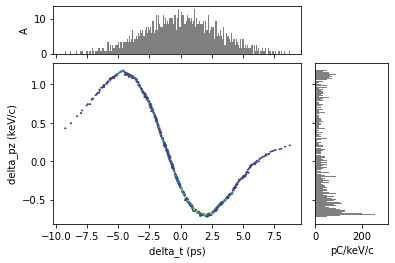

In [8]:
P = ParticleGroup(h5[ppaths[-1]])
P.plot('delta_t', 'delta_pz', bins=200)

In [9]:
os.remove(afile)

## evaluate examples

In [10]:
M.evaluate('lat::orbit.x[end]')

0.0